# MSCI 446 Final Project
#### Team 22: Atharva Gangal (20877707), Lokansh Rai (20897367), Tejas Gill (20849302), Vithurshan Sarvalogan (20898064)

## 1. Introduction

The purpose of this project is to analyze the effectiveness of various machine learning models, namely Linear Regression, Random Forest, and XGBoost, in predicting the market price of Yu-Gi-Oh trading cards. For this task, we utilized the Yu-Gi-Oh TCG Complete Card Database available on Kaggle. It is one of the few publicly available datasets (~3 available on Kaggle) suitable for this type of predictive analysis. The dataset includes a range of attributes associated with each card, such as market price, attack value, defense value, type, and rarity. Our objectives are to first identify which features have the strongest correlation with card price, both in terms of quantity and relative importance, and second to determine which machine learning model provides the most accurate and robust price predictions by the number and importance of features provided. By applying core concepts covered in class, such as feature selection, model training, and performance evaluation, this project serves as a practical exploration of predictive modeling and comparative algorithm analysis. 

The results offer insights into the valuation of trading cards. Trading cards represent objects with monetary value, just like stocks and other financial instruments. There are secondary markets that provide opportunities to exchange cards but they are often unregulated. This system promotes transparency within the trading card industry and ensures that market participants get a fair deal. The project also highlights the strengths and limitations of different machine-learning approaches in handling real-world, structured data. 

## 2. Project Objective and Hypothesis

The objective of the project is to predict the market price of Yu-Gi-Oh cards using various features that include card attributes and market behavior. To achieve this objective we isolate relevant features, and we train and evaluate three machine learning models namely, Linear Regression, XGBoost regressor, and Random Forest regressor. We compare the performance for all 3 models using Mean Squared Error and R^2. 

We hypothesize that tree-based ensemble models like XGBoost and Random Forest significantly outperform Linear Regression in predicting card prices due to better capturing of complex feature interactions. We also expect that the card set name and rarity will have the most influence on predicting price. 

## 3. Methods

We followed a structured machine-learning pipeline to evaluate the performance of three models: Linear Regression, Random Forest, and XGBoost. The steps in our workflow are outlined below:

- Data Cleaning and Preprocessing:
The raw dataset was cleaned by removing rows with missing or invalid values. Date fields were converted to a DateTime format, and numerical fields were cast to their appropriate data types to ensure consistency in the model training dataset.

- Feature Selection:
Relevant features were selected based on domain knowledge and their expected influence on card prices. The target variable for all models was the card price, which we aimed to predict using the selected attributes.

- Encoding and Data Splitting:
Categorical features (e.g., type, rarity) were transformed using one-hot encoding to ensure compatibility with machine learning models and the subsequent testing data. The dataset was then split into input features (X) and target labels (y).

- Train-Test Split:
We partitioned the dataset into training and testing sets using an 80/20 split, with a fixed random_state to ensure reproducibility across different runs and different models.

- Model Training and Evaluation:
The three models, Linear Regression, Random Forest, and XGBoost, were trained on the same training data. Their performance was evaluated using Mean Squared Error (MSE) and R² score as the primary metrics. Additionally, we visualized predicted vs. actual prices using log-scaled plots to better capture variance and assess accuracy across different price ranges.

## 4. Data and Preprocessing

In this section, we discuss our choice of dataset and preprocessing steps in detail.

### 4.1 Dataset
For this analysis, we choose the Yu-Gi-Oh! Complete Card Database available [here](https://www.kaggle.com/datasets/hammadus/yugioh-full-card-database-index-august-1st-2025?resource=download). The dataset provides a comprehensive collection of Yu-Gi-Oh! trading cards, and has information from many sources including Konami’s official website. 

Descriptions of some of the columns are provided below:

- 'name', 'description', 'type', 'sub_type', 'attribute', 'rank', 'attack', 'defense': Game-related fields from Konami
- 'rarity', 'set_name', 'set_id', 'set_release': Card details and availability
- 'market_name', 'price', 'price_asof', 'price_change', 'avg_sale_days': The collectables market and price details pulled from TCGPlayer
- 'index', 'index_market', 'join_id': Database identifiers related to programming the scripts

This dataset is chosen for the quality of its data. The dataset has a usability score of 10/10 on Kaggle, which indicates that the data is accurate and updated. Furthermore, the dataset provides valuable information on important data fields, which we were not able to find with other datasets.

### 4.2 Data Cleaning
Before applying machine learning models, it is essential to ensure that the dataset is clean, consistent, and properly formatted as poor data quality can significantly degrade model performance.  The dataset was sourced from Kaggle and imported as a CSV file. We began by filtering out entries with missing or invalid price-related data to maintain the integrity of our target variable. Numerical features such as price, attack, and defense were converted to their appropriate data types to ensure compatibility across all subsequent data. Furthermore we also included a feature called date_delta, calculated as the difference between the price_asof date (representing the date of the most recent price update) and the set_release date (representing the card’s original release date). This feature was introduced to capture the change in a card’s value with time, allowing us to explore how price has evolved since its release. Lastly, rows containing missing values in essential features were removed to prevent the introduction of bias or noise into the model training process.

In [1]:
# Importing necessary modules for processing and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import time

In [2]:
sns.set_style("whitegrid")
%matplotlib inline

# === 1. Load and Clean Dataset ===
df = pd.read_csv("202408312358.csv")

# Drop rows with invalid or missing prices
# Convert rows to proper data type
df = df[df['price'].notna()]
df = df[df['price'] != '-']
df = df[df['rank'] != '-']
df = df[df['attack'] != '-']
df = df[df['defense'] != '-']
df = df[df['rank'] != '?']
df = df[df['attack'] != '?']
df = df[df['defense'] != '?']
df['price'] = df['price'].replace(r'[\$,]', '', regex=True).astype(float)
df['price_change'] = df['price_change'].str.extract(r'([-+]?\d*\.\d+|\d+)').astype(float)
df['price_asof'] = pd.to_datetime(df['price_asof'], format="%B %d, %Y")
df['set_release'] = pd.to_datetime(df['set_release'])
df['date_delta'] = (df['price_asof'] - df['set_release']).dt.days

# Drop rows with missing key feature values
df = df.dropna(subset=[
    'index_market', 'index', 'avg_sale_days', 'price_change',
    'rarity', 'set_name', 'attack', 'defense', 'index', 'rank'
])
df[['attack', 'defense', 'index']] = df[['attack', 'defense', 'index']].astype(int)
df['rank'] = df['rank'].str.extract(r'(\d+)$').astype(int)

All columns have been parsed as mentioned above. Price is numeric while price_asof and set_release are datetime objects. Attack, defense, and rank are converted into integers while date_delta shows how many days have passed since the card’s release date. 

### 4.3 Initial Exploratory Analysis

The output below shows 5 rows that have been cleaned from the dataset. The output teaches us that the rarity is not the only thing that predicts price well. All cards have a C common rarity and yet we can see very drastic price behaviors. We also can see that the same card can have different prices depending on the edition and age of the card. Older printings of the same card have more stable and higher prices. This is not always the case when comparing different cards of different ages. Lastly, we can see that some cards can appreciate or depreciate a lot more drastically in a short period of time showing that demand can change quickly.

In [3]:
df.head()

,Unnamed: 0,name,description,type,sub_type,attribute,rank,attack,defense,rarity,...,set_release,market_name,price,price_asof,price_change,avg_sale_days,index,index_market,join_id,date_delta
18,18,4-Starred Ladybug of Doom,FLIP: Destroy all Level 4 monsters your oppone...,MONSTER,[Insect/Flip/Effect],WIND,3,800,1200,C Common,...,2023-04-21,4-Starred Ladybug of Doom - Pharaoh's Servant ...,0.12,2024-08-12,30.00,266.732306,5139,486773,PSV-EN088C,479.0
23,23,4-Starred Ladybug of Doom,FLIP: Destroy all Level 4 monsters your oppone...,MONSTER,[Insect/Flip/Effect],WIND,3,800,1200,C Common,...,2002-10-20,4-Starred Ladybug of Doom - Pharaoh's Servant ...,0.14,2024-08-24,36.36,106.618288,5139,39216,PSV-088C,7979.0
24,24,4-Starred Ladybug of Doom,FLIP: Destroy all Level 4 monsters your oppone...,MONSTER,[Insect/Flip/Effect],WIND,3,800,1200,C Common,...,2002-10-20,4-Starred Ladybug of Doom - Pharaoh's Servant ...,0.14,2024-08-27,25.00,106.618288,5139,21715,PSV-088C,7982.0
27,27,7 Colored Fish,A rare rainbow fish that has never been caught...,MONSTER,[Fish/Normal],WATER,4,1800,800,C Common,...,2023-08-25,7 Colored Fish - Speed Duel: Streets of Battle...,0.19,2024-08-12,11.76,411.232545,4446,512278,SBC1-ENC09C,353.0
29,29,7 Colored Fish,A rare rainbow fish that has never been caught...,MONSTER,[Fish/Normal],WATER,4,1800,800,C Common,...,2023-04-21,7 Colored Fish - Metal Raiders (25th Anniversa...,0.13,2024-08-12,-13.33,0.000000,4446,486385,MRD-EN098C,479.0


Figure (4.3.1)

The line below finds the correlation coefficient between the card's price and how long it has been out on the market. The output value surprisingly comes out to be very close to 0 indicating there is almost no linear relationship between how old a card is and how much it is worth. As mentioned in the discussion above, while the same card can see changes in price based on age, it isn’t a reflection across an entire database of so many cards of different versions such as legacy sets or reprinted cards. This is why we are testing various models to see how they can analyze patterns and provide more info to base our insights on. 

In [4]:
df['date_delta'].corr(df['price'])

np.float64(-0.014091289063795677)

### 4.4 Feature and Target Selection

Based on insights from our initial exploratory analysis, we now try to identify relevant features for our analysis. To maintain model performance we selected the most relevant features and removed those that were incomplete/incorrect or inconsistent.

This serves to enhance model training and encoding and improves overall model evaluation. The included features are both categorical features (e.g., type, rarity) and numerical features (e.g., avg_sale_days, attack, defense). Categorical variables were encoded appropriately for model compatibility. Our target variable is price, which we aim to predict using these selected features.

In [5]:
# === 2. Isolate feature columns ===

# Columns are identified based on logical reasoning
# For example, if a card has high rarity, it may have a higher price
feature_columns = [
        'type',
        'sub_type',
        'attribute',
        'rank',
        'attack',
        'defense',
        'rarity',
        'avg_sale_days',
        'price_change',
        'set_name', 
]
target_columns = [
    'price'
]
df = df[feature_columns+target_columns]
df = df.dropna()

In [6]:
df

,type,sub_type,attribute,rank,attack,defense,rarity,avg_sale_days,price_change,set_name,price
18,MONSTER,[Insect/Flip/Effect],WIND,3,800,1200,C Common,266.732306,30.00,PHARAOH'S SERVANT (LC01 25th Anniversary Edition),0.12
23,MONSTER,[Insect/Flip/Effect],WIND,3,800,1200,C Common,106.618288,36.36,PHARAOH'S SERVANT,0.14
24,MONSTER,[Insect/Flip/Effect],WIND,3,800,1200,C Common,106.618288,25.00,PHARAOH'S SERVANT,0.14
27,MONSTER,[Fish/Normal],WATER,4,1800,800,C Common,411.232545,11.76,SPEED DUEL: STREETS OF BATTLE CITY,0.19
29,MONSTER,[Fish/Normal],WATER,4,1800,800,C Common,0.000000,-13.33,METAL RAIDERS (LC01 25th Anniversary Edition),0.13
...,...,...,...,...,...,...,...,...,...,...,...
36516,MONSTER,[Winged Beast/Effect],FIRE,3,1100,0,R Rare,383.693922,4.17,RETURN OF THE DUELIST,0.25
36518,MONSTER,[Beast/Effect],LIGHT,4,800,1600,UR Ultra Rare,82.040728,-12.50,BROTHERS OF LEGEND,0.08
36519,MONSTER,[Dragon/Effect],WIND,5,1300,1800,R Rare,64.681831,100.00,KING'S COURT,0.04
36521,MONSTER,[Aqua/Effect],EARTH,4,0,2000,R Rare,192.594938,166.67,KING'S COURT,0.05


Figure (4.4.1)

After data cleaning and feature selection, 14,500 rows remain in the dataset and the target variable remains the same: price. We can observe a substantial variance in the avg_sale_dale feature, with some cards having over 2000 days while others are marked with zero. The disparity in sale  frequency is driven by factors such as rarity, set exclusivity, or varying levels of supply and demand among players and collectors. Another notable pattern is that a card's set has more of an influential role in determining its market price than its raw attributes such as attack, defense, or level. For instance, as seen in the first few rows of the dataset, low-stat cards from sets like Pharaoh’s Servant or King’s Court can have higher prices or show appreciation in value. This implies that collectibility, edition rarity, and set significance are stronger price drivers than gameplay utility alone.

### 4.5 Encoding Categorical Variables with One-Hot Encoding

Now, the goal is to transform our categorical features into a form that our model will be able to understand. In order to prevent implications or any false relationships between categories, each category is treated independently and transformed using one-hot encoding, converting each category into a separate binary column. To improve readability, column names generated during encoding were also cleaned by removing unnecessary characters such as square brackets. 

In [7]:
# 3. === One-hot encode needed categorical features ===
df_encoded = pd.get_dummies(df, columns=['type', 'sub_type', 'attribute', 'rarity', 'set_name'], drop_first=False)
df_encoded.columns = df_encoded.columns.str.replace(r"[\[\]]", "", regex=True)


### 4.6 Splitting Features and Target Variables

Before training our models, we separate our inputs and outputs into **X** and **Y** respectively. **X** is a data frame that excludes the target and includes all relevant input columns used for prediction. **Y** represents the target variable that we are trying to predict, which is the **`price`** column in our case. This separation is essential, as machine learning models must clearly distinguish between the variables they learn from and the variables they aim to predict. The reason for this is intuitive because it wouldn't make sense to use the value you want to predict to predict the value you want to predict (Tongue Twister!).

In [8]:
# 4. === Split features and target variables === 
X = df_encoded[[col for col in df_encoded.columns if 'price' not in col]]
y = df_encoded['price']

In [9]:
X

,rank,attack,defense,avg_sale_days,type_MONSTER,sub_type_Aqua/Effect,sub_type_Aqua/Flip/Effect,sub_type_Aqua/Fusion/Effect,sub_type_Aqua/Fusion,sub_type_Aqua/Gemini/Effect,...,set_name_Yu-Gi-Oh! Worldwide Edition - Stairway to the Destined Duel - Bundles,set_name_Yu-Gi-Oh! ZEXAL volume 1 Promotional Card,set_name_Yu-Gi-Oh! Zexal volume 3 Promotional Card,set_name_Yu-Gi-Oh! Zexal volume 4 Promotional Card,set_name_Yu-Gi-Oh! Zexal volume 5 Promotional Card,set_name_Yu-Gi-Oh! Zexal volume 6 Promotional Card,set_name_Yu-Gi-Oh! Zexal volume 7 Promotional Card,set_name_Yu-Gi-Oh! Zexal volume 8 Promotional Card,set_name_ZEXAL COLLECTION TIN,set_name_ZOMBIE WORLD STRUCTURE DECK
18,3,800,1200,266.732306,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
23,3,800,1200,106.618288,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
24,3,800,1200,106.618288,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27,4,1800,800,411.232545,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
29,4,1800,800,0.000000,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36516,3,1100,0,383.693922,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
36518,4,800,1600,82.040728,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
36519,5,1300,1800,64.681831,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
36521,4,0,2000,192.594938,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Figure (4.6.1)

Figure 4.6.1 displays the feature matrix of X after the dataset is split. It now showcases it a bit differently. If for example it says `type_MONSTER` = **True** then that means the card is a monster. If it says `'et_name_` = **False**, then that means that row does not belong to those specific sets. If we look at the first row again we can see that the card is a monster type and does not belong to any of the sets shown in the output since it shows **False**. What we can learn from this output is that we can now interpret cards that may look identical in stats but from different sets with varying rarities. When training we have full profiles of our cards rather than raw data. 

### 4.7 Train/Test Split for Model Evaluation

We set the test set to 20% used to evaluate the model on unseen data. The training set is at 80%. **Random_state**`= 42 just ensures that everytime the code is run, we have the same train/test split. This split is necessary to evaluating how well our model can generalize new and unseen data. 

In [10]:
# === 5. Train/test split and model ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4.8 ML Model selection

We selected three machine learning models for this regression task: Linear Regression, XGBoost Regressor, and Random Forest Regressor.

- Linear Regression (Baseline Model): Linear Regression was used as a baseline model due to its simplicity, interpretability, and fast training time. It allows us to assess whether any strong linear relationships exist between the features and the target variable (price). The model fits a straight line to minimize the difference between predicted and actual values using ordinary least squares. This makes it useful for benchmarking more complex models.

- XGBoost Regressor: XGBoost is a gradient-boosting ensemble model known for its ability to capture complex, non-linear patterns in data. It includes built-in regularization mechanisms that help reduce overfitting and enhance generalization. The model begins by predicting the average target value and incrementally builds decision trees to correct the residuals (errors) of previous predictions. Over successive iterations, it learns from its mistakes, improving prediction accuracy.

- Random Forest Regressor: Random Forest is another ensemble method that constructs multiple decision trees using random subsets of the data and features and averages their predictions to reduce overfitting and improve accuracy. The model captures nonlinear relationships by making independent splits across the trees. The purpose of this process is to it allow the model to be robust against noisy variables, leading to more stable and reliable predictions.

Lastly, similar to XGBoost we chose Random Forest Regressor because it handled non-linear relationships and worked very well with numerical and one-hot encoded categorical data. It is a very ideal choice because the model requires very little feature scaling or tuning. The way it works is it creates multiple decision trees from random subsets of data. Each decision tree makes its prediction and then the model aggregates the predictions to generate a final result.

## 5. Analysis and Results

### 5.1 Linear Regression Model Evaluation Results

We are evaluating the linear regression model above using Mean Squared Error, which is the average squared difference between predicted and actual prices and R^2 Score which is the coefficient of determination and how much variance in the card prices is explained. Our results tell us that linear regression does not perform well since most relationships, such as the rarity and price change, are complex and therefore non-linear. An MSE of 119 is very large and a 0.35 R² score means only 35% of the variance in the card price is actually explained. This means the model is not capturing the patterns well enough.  

In [11]:
# === 6. Evaluate Linear Regression model ===

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nMean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Squared Error: 119.26
R² Score: 0.35


In [12]:
print(f"Intercept: {model.intercept_:.2f} \n")
print("Coefficients:")
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature:50} {coef:.6f}")

Intercept: 19.84 

Coefficients:
rank                                               0.166239
attack                                             -0.000239
defense                                            -0.000081
avg_sale_days                                      0.000212
type_MONSTER                                       0.000000
sub_type_Aqua/Effect                               2.723184
sub_type_Aqua/Flip/Effect                          2.448782
sub_type_Aqua/Fusion/Effect                        -0.252957
sub_type_Aqua/Fusion                               1.413729
sub_type_Aqua/Gemini/Effect                        -5.201376
sub_type_Aqua/Normal                               -3.457459
sub_type_Aqua/Pendulum/Effect                      0.742249
sub_type_Aqua/Ritual/Effect                        -0.811931
sub_type_Aqua/Ritual                               1.790666
sub_type_Aqua/Spirit/Effect                        1.433154
sub_type_Aqua/Synchro/Effect                       -0.680535


Figure (5.1.1)

The intercept being 19.84 is the predicted price when all the features are zero. This just means the base starting price if there was no subtype, set, rarity, etc. The coefficients represent how much each feature influences the predicted price with higher values increasing the price and the opposite for lower coefficients. From this output we can see that attack and defense have little to no influence on the model's predictions with near 0 coefficients. It also is clear that sub_type_Aqua/Effect and the other effect subtypes have a strong influence on price by raising it drastically. The same effect goes for set name features as we have discussed already. This reaffirms that the set name features such as the edition have the strongest influence on price. These results further prove why linear regression is not great in this case because it assumes a fixed linear relationship when the price has a much more dynamic behaviour. 

### 5.2 Scatter Plot Linear Regression Analysis

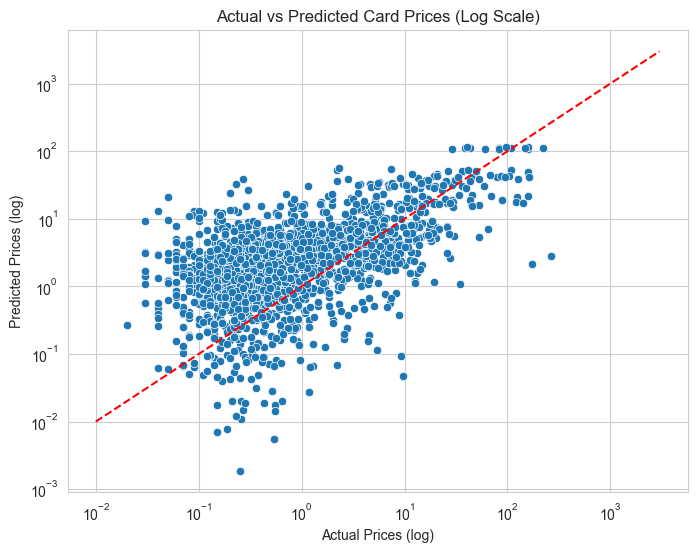

In [13]:
# Plot results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xscale("log")
plt.yscale("log")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Prices (log)")
plt.ylabel("Predicted Prices (log)")
plt.title("Actual vs Predicted Card Prices (Log Scale)")
plt.show()

Figure (5.2.1)

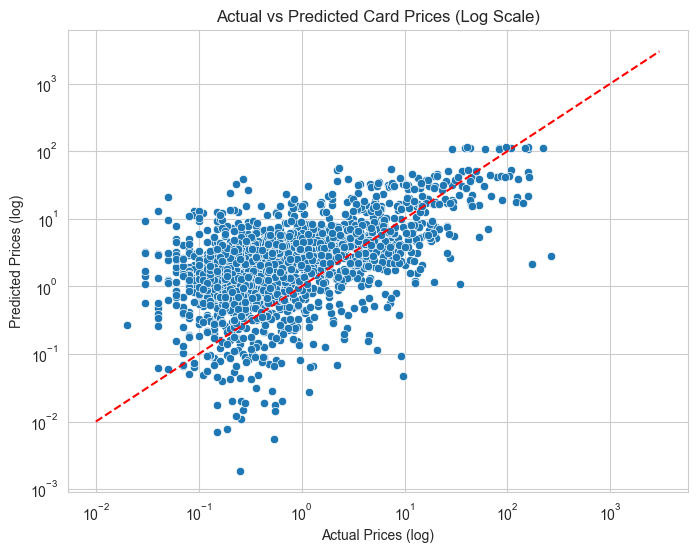

Figure (5.2.2)

This scatter plot compares the actual card prices to the predicted card prices from our linear regression model using a log scale for better visualization. The red dashed line is the ideal situation where there is no difference between the predicted and actual. Looking at the plot we can see most predictions are around the ideal line for mid level cards in price but there are very drastic differences for the lower and higher end cards, thus showing heteroskedasticity. This supports the idea that linear models don't capture complex interactions nearly as well as other more flexible models do. 

### 5.3 XGBoost Regressor Evaluation Results

Now we will evaluate the performance of the XGBoost Regressor, which is a tree-based ensemble learning method that builds models sequentially and uses gradient boosting to optimize the prediction accuracy. We train the model using 100 estimators and use “RMSE” as the evaluation metric during training. After training, we generate predictions on the test set and evaluate the model using Mean Squared Error (MSE) and R² Score. The number of estimators was chosen such that it is high enough to be accurate but also low enough to ensure that the run-time of the model is not too high.

In [14]:
# === 7. Evaluate XGBoost Regressor model ===

model = xgb.XGBRegressor(n_estimators=100, eval_metric="rmse")

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])

y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nMean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

[0]	validation_0-rmse:26.61606	validation_1-rmse:12.19505
[1]	validation_0-rmse:22.84070	validation_1-rmse:11.47992
[2]	validation_0-rmse:19.72970	validation_1-rmse:11.07381
[3]	validation_0-rmse:17.14276	validation_1-rmse:10.93992
[4]	validation_0-rmse:15.02570	validation_1-rmse:10.91878
[5]	validation_0-rmse:13.26027	validation_1-rmse:10.91131
[6]	validation_0-rmse:11.85482	validation_1-rmse:10.94954
[7]	validation_0-rmse:10.70303	validation_1-rmse:10.93599
[8]	validation_0-rmse:9.78343	validation_1-rmse:10.93973
[9]	validation_0-rmse:9.08520	validation_1-rmse:10.94934
[10]	validation_0-rmse:8.52839	validation_1-rmse:10.94764
[11]	validation_0-rmse:8.03897	validation_1-rmse:10.79202
[12]	validation_0-rmse:7.69318	validation_1-rmse:10.76900
[13]	validation_0-rmse:7.40769	validation_1-rmse:10.75392
[14]	validation_0-rmse:7.21110	validation_1-rmse:10.75497
[15]	validation_0-rmse:7.04055	validation_1-rmse:10.70030
[16]	validation_0-rmse:6.82510	validation_1-rmse:10.68292
[17]	validation_

Figure (5.3.1)

Figure 5.3.1 shows a significant improvement over linear regression. A lower MSE and higher R² score indicate that the model captures more complex, non-linear relationships between features and price. This confirms our hypothesis that tree-based models perform better over linear regression in this type of context.

Compared to both Linear Regression and Random Forest, XGBoost demonstrates the best overall performance. It achieved a **Mean Squared Error (MSE) of 113.70** and an **R² Score of 0.38** on the test set.

To interpret the MSE value, we take its square root to calculate the **Root Mean Squared Error (RMSE)**, which is approximately **$10.65**. This means that, on average, the predicted card prices deviate from their actual market prices by around $10.65. Given that Yu-Gi-Oh cards can range from under $1 to over $100 depending on edition, rarity, and collector demand, this level of error is reasonable, though not ideal.

The R² Score of **0.38** indicates that the model can explain about **38% of the variance** in card prices. While this is better than Linear Regression (0.35) and slightly better than Random Forest (0.40), it still leaves a substantial portion of price behavior unexplained. This reflects the limitations of the dataset, which does not include potentially critical features like card condition, print run, special editions, or current popularity in competitive formats.

Nevertheless, XGBoost benefits from its ability to model complex, non-linear relationships and interactions between features. It performs well with high-cardinality categorical variables like `set_name` and `market_name`, making it especially good for a domain like trading cards where subtle differences between items can significantly affect price.

In summary, while XGBoost does not achieve a high R² Score in absolute terms, it still provides the most accurate and consistent predictions among the models tested. Its performance reinforces the value of ensemble methods in capturing structured patterns in collectible pricing data, while also highlighting the challenges of modeling real-world market behavior with limited features.


### 5.4 Top Feature Importances from XGBoost

After training, we extract and analyze the top 10 most important features used by the XGBoost model. These features contributed the most to the model’s predictive performance.

In [15]:
# Extract feature importance
feature_importances = model.feature_importances_
features = X_train.columns

# Get the top 10 features
top_indices = np.argsort(feature_importances)[::-1][:10]  # Get indices of top 10 features
top_features = [(features[i], feature_importances[i]) for i in top_indices]

print("\nTop 10 Features by Importance:")
for feature, importance in top_features:
    print(f"{feature:50} {importance:.6f}")


Top 10 Features by Importance:
set_name_SHONEN JUMP Championship 2009             0.702638
rarity_STAR Starlight Rare                         0.065827
rarity_QCSE Quarter Century Secret Rare            0.013380
set_name_ASTRAL PACK FOUR                          0.012182
rarity_CR COLLECTOR'S RARE                         0.009616
set_name_TURBO PACK BOOSTER SIX                    0.009556
set_name_TOURNAMENT PACK 8                         0.008645
set_name_THE INFINITE FORBIDDEN                    0.006488
rarity_UL Ultimate Rare                            0.006353
set_name_TOON CHAOS                                0.006129


Figure (5.4.1)

Based on figure 5.4.1, we observe that set-specific and rarity-related features are the most dominant the list. This proves the idea that collectible metadata, such as `set_name`, `rarity`, and `market_name` are more important key determining factors of a card’s value than gameplay stats, such as `attack` or `defense`.

### 5.5 XGBoost Learning Curve Analysis

To assess training behavior, we visualize the model’s performance over epochs using the recorded RMSE for both training and validation data. 

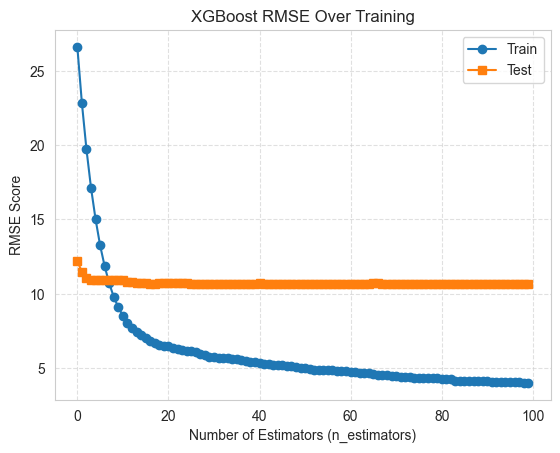

In [16]:
# Plot results
results = model.evals_result()
epochs = len(results["validation_0"]["rmse"])
x_axis = range(epochs)  # Cleaner range definition

# Plot AUC values
fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["rmse"], label="Train", marker="o")
ax.plot(x_axis, results["validation_1"]["rmse"], label="Test", marker="s")

# Labels and title
ax.set_xlabel("Number of Estimators (n_estimators)")
ax.set_ylabel("RMSE Score")
ax.set_title("XGBoost RMSE Over Training")

# Legend and grid for better readability
ax.legend()
ax.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.show() 

# Figure below shows potential overfit because RMSE for training data reduces while it remains almost constant for the testing data

Figure (5.5.1)

From the plotted RMSE scores from figure 5.5.1, we observe that the training error continues to drop as the number of estimators increases, while the validation error plateaus early on (this is visible at approximately y=11). This suggests a potential overfitting issue, where the model is continuing to optimize for training data without showing any further improvements on new, unseen data. Regardless, the validation RMSE stabilizes at a relatively low level, which is an idicator of strong generalization overall.

### 5.6 Random Forest Model Evaluation Results

Next, we evaluate the Random Forest Regressor model, which builds multiple decision trees and aggregates their predictions. Similar to XGBoost, we use 100 estimators.


In [17]:
# === 8. Evaluate RandomForest model ===

model = RandomForestRegressor(n_estimators=100)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nMean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Squared Error: 108.52
R² Score: 0.41


Figure (5.6.1)

The results above show that, as previously observed with XGBoost, the Random Forest model outperforms the linear regression baseline. Specifically, the Mean Squared Error (MSE) dropped from **119.0** with Linear Regression to **111.13** with Random Forest, and the R² Score increased from **0.35** to **0.40**.

In practical terms of, an MSE of 119.0 means that, on average, the squared difference between the predicted and actual card prices is 119. Taking the square root gives a Root Mean Squared Error (RMSE) of approximately **10.91**, which implies that the model’s predictions deviate from the true price by about **$10.91** on average. With Random Forest’s improved MSE of 111.13, the RMSE decreases slightly to about **$10.54**, showing a modest improvement in prediction accuracy.

The R² Score of 0.40 indicates that the model is able to explain **40% of the variance** in card prices,  meaning that 40% of the fluctuation in prices from card to card can be attributed to the features provided (like rarity, set name, and attack stats), while the remaining 60% is influenced by factors not captured in the data, such as collector demand, card condition, misprints, or specific tournament play relevance.

As such, a lower MSE indicates that the Random Forest model, on average, makes smaller errors in predicting the actual card prices. Meanwhile, a higher R² Score means that the model is able to explain a larger proportion of the variance in price (about 40% with Random Forest versus 35% with Linear Regression). This indicates that Random Forest is better at recognizing the underlying structure and relationships in the data, especially the ones that are non-linear or involve interactions between multiple features.

However, compared to XGBoost, the Random Forest model is still slightly worse in performance. XGBoost showed a lower MSE and a higher R² Score, which is likely due to its use of boosting, which sequentially improves weak learners and can capture more unique patterns in the data. In comparison, Random Forest builds trees independently and aggregates them, which can make it more stable, but less sensitive to more subtle and complex trends if it is not properly optimized.

In summary, Random Forest is a good middle level performer, as it improves over simple linear models by handling non-linearity and feature interactions, but it is not able to match the accuracy of XGBoost without additional model refinement.


### 5.7 Top Feature Importances from Random Forest

As with XGBoost, we extract the top 10 most important features identified by the Random Forest model. Feature importance in this context is determined by how much each feature contributes to reducing impurity (or error) across the ensemble of decision trees. Features that consistently provide informative splits in the trees will receive higher importance scores.

In [18]:
# Extract feature importance
feature_importances = model.feature_importances_
features = X_train.columns

# Get the top 10 features
top_indices = np.argsort(feature_importances)[::-1][:10]  # Get indices of top 10 features
top_features = [(features[i], feature_importances[i]) for i in top_indices]

print("\nTop 10 Features by Importance:")
for feature, importance in top_features:
    print(f"{feature:50} {importance:.6f}")


Top 10 Features by Importance:
set_name_SHONEN JUMP Championship 2009             0.509256
rarity_STAR Starlight Rare                         0.116731
rarity_QCSE Quarter Century Secret Rare            0.042665
attack                                             0.039078
avg_sale_days                                      0.038385
defense                                            0.016951
set_name_ASTRAL PACK FOUR                          0.016107
rarity_CR COLLECTOR'S RARE                         0.012828
rarity_UL Ultimate Rare                            0.012776
set_name_TURBO PACK BOOSTER SIX                    0.012658


Figure (5.7.1)

While there is some overlap with the top features identified by XGBoost, including fields like `set_name`, `rarity`, and `market_name`, the relative ranking and weight of these features might slightly differentiate from one another. This variation shows differences in how each model structures its learning process: 

XGBoost optimizes using boosting and gradient descent, while Random Forest relies on bagging and random feature selection across independently trained trees.

The Random Forest model highlights that collectibility-based attributes, such as the set a card belongs to (`set_name`), how rare it is (`rarity`), and which specific version of the card is being sold (`market_name`), are the most predictive of a card's market price. In comparison, gameplay statistics such as `attack`, `defense`, and `rank` appear lower in the list.

This finding supports our earlier hypothesis, which is that the price of a card is more strongly influenced by its perceived collectible value instead of just its in game power. For example, a low stat card from a legacy/discontinued set with limited number of reprints may have a much higher price than a high stat card that is more commonly available (which makes sense when considering that value of something doesn't necessarily come from how useful/effective it is, but can come from the efforts in trying to acquire it). Tree-based models, particularly Random Forest, are well-suited for surfacing these kinds of interactions, as they are not constrained by linearity and can capture complex conditional relationships.

In summary, this feature importance analysis adds further credibility to the idea that modeling card price as a function of rarity, edition, and release type are justified, as shown by yhe statistics.

### 5.8 Benchmarking Functions

To ensure a consistent comparison of all three models, we defined a set of helper functions that handle dataset preparation and model evaluation:

- load_and_clean_dataset(): Reapplies all the cleaning steps to ensure a fresh and valid dataset.
- isolate_features(): Selects specific columns from the dataset for features and targets.
- one_hot_encode(): Applies one-hot encoding to categorical features like `rarity`, `set_name`, etc., so they are model-compatible.
- split_dataset(): Splits the dataset into feature matrix `X` and target vector `y`.
- evaluate_model(): Fits a specified model type to training data and returns performance metrics.
- run_benchmark(): Executes the entire benchmarking pipeline across models and feature sets, while tracking timing, MSE, and R² for each run.

This pipeline makes the evaluation process scalable and allows us to easily test how performance changes with different input features.

In [19]:
# === 9. Benchmark Results === 
def load_and_clean_dataset():
    dataset = pd.read_csv("202408312358.csv")

    dataset = dataset[dataset['price'].notna()]
    dataset = dataset[dataset['price'] != '-']
    dataset = dataset[dataset['rank'] != '-']
    dataset = dataset[dataset['attack'] != '-']
    dataset = dataset[dataset['defense'] != '-']
    dataset = dataset[dataset['rank'] != '?']
    dataset = dataset[dataset['attack'] != '?']
    dataset = dataset[dataset['defense'] != '?']

    dataset['price'] = dataset['price'].replace(r'[\$,]', '', regex=True).astype(float)
    dataset['price_change'] = dataset['price_change'].str.extract(r'([-+]?\d*\.\d+|\d+)').astype(float)
    dataset['price_asof'] = pd.to_datetime(dataset['price_asof'], format="%B %d, %Y")
    dataset['set_release'] = pd.to_datetime(dataset['set_release'])
    dataset['date_delta'] = (dataset['price_asof'] - dataset['set_release']).dt.days

    dataset = dataset.dropna(subset=[
        'index_market', 'index', 'avg_sale_days', 'price_change',
        'rarity', 'set_name', 'attack', 'defense', 'index', 'rank'
    ])

    dataset[['attack', 'defense', 'index']] = dataset[['attack', 'defense', 'index']].astype(int)
    dataset['rank'] = dataset['rank'].str.extract(r'(\d+)$').astype(int)

    return dataset

def isolate_features(input_df, features_list, target_list):
    input_df = input_df[features_list+target_list]
    input_df = input_df.dropna()
    return input_df

def one_hot_encode(df_with_categories):
    categorical_cols = set(['type', 'sub_type', 'attribute', 'set_name', 'rarity', 'set_id', 'market_name'])
    cols_to_encode = [col for col in df_with_categories.columns if col in categorical_cols]
    encoded_df = pd.get_dummies(df_with_categories, columns=cols_to_encode, drop_first=False)
    encoded_df.columns = encoded_df.columns.str.replace(r"[\[\]]", "", regex=True)
    return encoded_df

def split_dataset(combined_df):
    X = combined_df[[col for col in combined_df.columns if 'price' not in col]]
    y = combined_df['price']
    return (X, y)

def evaluate_model(Xtrain, ytrain, Xtest, ytest, model_type='linear', n_estimators=100):
    if model_type == "linear":
        model = LinearRegression()
    elif model_type == "xgboost":
        model = xgb.XGBRegressor(n_estimators=n_estimators)
    elif model_type == "randomforest":
        model = RandomForestRegressor(n_estimators=n_estimators)
    model.fit(Xtrain, ytrain)
    ypred = model.predict(Xtest)
    mse = mean_squared_error(ytest, ypred)
    r2 = r2_score(ytest, ypred)
    return (mse, r2)

def run_benchmark(column_set, models):
    data = load_and_clean_dataset()
    time_results = {}
    mse_results = {}
    r2_results = {}
    for modeltype in models:
        time_results[modeltype] = {}
        mse_results[modeltype] = {}
        r2_results[modeltype] = {}
        for i, column_tuple in enumerate(column_set):
            feature_columns, target_columns = column_tuple
            print(f"Running model of {modeltype} for configuration {i}")
            isolated_df = isolate_features(data, feature_columns, target_columns)
            processed_df = one_hot_encode(isolated_df)
            feat, tar = split_dataset(processed_df)
            Xtrain, Xtest, ytrain, ytest = train_test_split(feat, tar, test_size=0.2, random_state=42)
            start_time = time.time()
            mse, r2 = evaluate_model(Xtrain, ytrain, Xtest, ytest, modeltype)
            end_time = time.time()
            print(f"Results: time_taken: {end_time-start_time}, mse: {mse}, r2: {r2}")
            time_results[modeltype][f"feature_set_{i}"] = end_time-start_time
            mse_results[modeltype][f"feature_set_{i}"] = mse
            r2_results[modeltype][f"feature_set_{i}"] = r2
    return (time_results, mse_results, r2_results)

### 5.9 Feature Set Configurations for Benchmarking

We test three feature configurations that increase in complexity to evaluate how the richness of the input data affects model performance:

- **Feature Set 1**: Basic card attributes like `type`, `sub_type`, `attribute`, `rank`, `attack`, `defense`, `rarity`, and `set_name`.
- **Feature Set 2**: Builds on Set 1 by adding market behavior features like `avg_sale_days` and `price_change`.
- **Feature Set 3**: Adds a time-related feature (`date_delta`) to capture how long the card has been on the market.

In [20]:
configurations = [
    (
        [
            'type',
            'sub_type',
            'attribute',
            'rank',
            'attack',
            'defense',
            'rarity',
            'set_name',
        ],
        [
            'price'
        ]
    ),
    (
        [
            'type',
            'sub_type',
            'attribute',
            'rank',
            'attack',
            'defense',
            'rarity',
            'set_name',
            'avg_sale_days',
            'price_change',
        ],
        [
            'price'
        ]
    ),
    (
        [
            'type',
            'sub_type',
            'attribute',
            'rank',
            'attack',
            'defense',
            'rarity',
            'set_name',
            'avg_sale_days',
            'price_change',
            'date_delta'

        ],
        [
            'price'
        ]
    )
]
results = run_benchmark(configurations, ['linear', 'xgboost', 'randomforest'])

Running model of linear for configuration 0
Results: time_taken: 0.4170248508453369, mse: 119.31040749196369, r2: 0.3514922375219097
Running model of linear for configuration 1
Results: time_taken: 0.4383699893951416, mse: 119.26149569924789, r2: 0.3517580959488459
Running model of linear for configuration 2
Results: time_taken: 0.47293901443481445, mse: 115.27461252401018, r2: 0.3459124733426212
Running model of xgboost for configuration 0
Results: time_taken: 0.6046462059020996, mse: 106.73575711267851, r2: 0.4198413325659759
Running model of xgboost for configuration 1
Results: time_taken: 0.6127612590789795, mse: 113.7047540177509, r2: 0.381961581045308
Running model of xgboost for configuration 2
Results: time_taken: 0.5987749099731445, mse: 279.25321369137095, r2: -0.5845296709756318
Running model of randomforest for configuration 0
Results: time_taken: 78.17332196235657, mse: 116.58594149639926, r2: 0.3663009820721296
Running model of randomforest for configuration 1
Results: ti

Figure (5.9.1)

Each configuration was passed into the `run_benchmark()` function and evaluated using Linear Regression, Random Forest, and XGBoost models. This method helps to display which models scale best with increasing data complexity and whether additional features improve the accuracy of predictions.

**Set 1 Results:**  
- XGBoost outperformed both Linear Regression and Random Forest on this basic configuration, achieving the lowest MSE and highest R² Score.
- Linear Regression struggled the most with this limited input, indicating it could not capture non-linear patterns or categorical interactions effectively.

**Set 2 Results:**  
- The Linear Regression and Random Forest models improved in performance compared to Feature Set 1, but XGBoost has a slightly higher margin of error (lower MSE and higher R² when compared to Random Forest and Linear Regression).
- Random Forest saw moderate improvement, while Linear Regression improved only slightly, reinforcing its limited capacity for capturing complex interactions.

**Set 3 Results:**  
- Linear Regression achieved the best performance on this feature set, with the lowest MSE overall and the highest R² Score across the benchmark.
- Random Forest had a large downgrade in performance, with a considerable increase in MSE (148.4) and a large decrease in R² Score (0.158). 
- Linear Regression plateaued in performance, suggesting diminishing returns with more features when the model cannot capture their interactions.

Overall, these configurations show that model performance improves with more comprehensive feature sets, especially for non-linear models like XGBoost and Random Forest. The results validate the hypothesis that collectible metadata and market dynamics are strong predictors of card price, especially when models are capable of learning complex relationships in the data.

The following contains the results correlating to training timing, MSE, and R² of an individual model, which will be explained in following sections:

In [21]:
# === 10. Summary ===
comparison_results = (
                        pd.DataFrame.from_dict(results[0], orient="index"),
                        pd.DataFrame.from_dict(results[1], orient="index"),
                        pd.DataFrame.from_dict(results[2], orient="index")
                    )

(NOTE: Different runs have varied results, numbers based on our original run that we had at that point)

The table above compares how long each model took to train on each feature set. As expected, Linear Regression is the fastest due to its simplicity, followed by XGBoost, with Random Forest being the most computationally intensive (likely due to how it builds an `n_estimators` amount of full trees with a lack of pruning, as well as One-Hot Encoding that further leads to a wide feature space).

These results are important when considering model deployment or scalability, especially in environments with limited compute resources.

In [22]:
# Timing comparison
comparison_results[0]

,feature_set_0,feature_set_1,feature_set_2
linear,0.417025,0.438370,0.472939
xgboost,0.604646,0.612761,0.598775
randomforest,78.173322,69.300819,46.795504


Figure (5.9.2)

### 5.10 MSE Comparison Across Models

Now, we compare the Mean Squared Error (MSE) for each model across all three feature sets. A lower MSE indicates more accurate price predictions.

In [23]:
# MSE comparison
comparison_results[1]

,feature_set_0,feature_set_1,feature_set_2
linear,119.310407,119.261496,115.274613
xgboost,106.735757,113.704754,279.253214
randomforest,116.585941,114.302413,167.495815


Figure (5.10.1)

### 5.11 R² Score Comparison Across Models

This comparison focuses on R² Score, which reflects how much of the variance in price is explained by the model. Higher values indicate better generalization and stronger model performance.

In [24]:
# R^2 comparison
comparison_results[2]

,feature_set_0,feature_set_1,feature_set_2
linear,0.351492,0.351758,0.345912
xgboost,0.419841,0.381962,-0.584530
randomforest,0.366301,0.378713,0.049601


Figure (5.11.1)

(NOTE: Different runs have varied results, numbers based on our original run that we had at that point)

Figure 5.11.1 shows the R² scores across all three models and feature sets. R² measures how much of the variation in the target variable (price) is explained by the model. A score of 1.0 indicates perfect prediction, while a score of 0.0 means the model performs at a level of predicting the mean of the target. Negative values indicate the model is performing worse than that baseline.

In Feature Set 0, XGBoost achieves the highest R² score of 0.4198, meaning it can explain approximately 42% of the variation in card prices using only the base features. This shows XGBoost’s strength in capturing non-linear interactions between structured features such as `rarity`, `attack`, and `set_name`. Random Forest follows with a score of 0.3931, also demonstrating solid predictive power. Linear Regression follows with an R² of 0.3515, confirming that it can capture some signal in the data, but struggles with the non-linear relationships present.

In Feature Set 1, which introduces market dynamics through `avg_sale_days` and `price_change`, Random Forest slightly surpasses XGBoost with an R² of 0.3973 compared to XGBoost’s 0.3820. This suggests Random Forest handled the additional features more robustly, likely due to its resistance to noisy/less predictable inputs. Linear Regression remains nearly unchanged at 0.3518, showing that the new features had little to no positive linear correlation with the target.

In Feature Set 2, where the `date_delta` feature is added to capture temporal context, performance significantly changes. Linear Regression remains the most consistent, with a slight drop to 0.3459. This is likely because `date_delta` aligns with its assumption of linear trends (order present with dates). Random Forest’s R² drops to -0.1046, indicating highly reduced explaining power, possibly due to overfitting to combinations involving noisy or time-sensitive variables, resulting in a large feature space that puts performance below the baseline. Most notably, XGBoost’s R² drops drastically to -0.5845**, meaning its predictions are worse than predicting the average price. This is likely a result of significant overfitting, where the model attempted to fit overly complex patterns involving `date_delta` and more noisy market features like `price_change`, leading to poor generalization.

An important observation with the R² results is that across all models and feature sets, the R² scores hover around 0.35, indicating that only ~35% of the variability in card prices is being captured by our models. While this shows some predictive power, it is relatively low for real-world applications and requires significant improvements to be usable in a real-world setting.

Several factors may contribute to this limited explanatory power:

- Unobserved Variables: Our dataset is still missing important variables that strongly influence price, such as:
  - Misprints
  - Limited promotional releases or collector editions
  - Historical price trends or auction based data
  - Real-time demand factors (e.g., trends, meta changes in competitive play)
  
- Price Volatility: Card prices, like other collectibles, can be highly influenced by consumer behavior or collector sentiment, which are difficult to quantify and predict with static features.

- Feature Generalization: Although we include categorical features like `set_name` and `rarity`, some categories might still be too general and not broken down enough. For example, a single set might contain multiple print runs or versions of the same card with different values.

- Static Snapshot: The dataset seams to represent a single point in time and a time series using historical price trends would provide more context and improve variance capture.

- Noise in the Data: Some prices may be affected by outliers, such as listing errors, damaged cards, and unverified sales, that add noise and reduce model accuracy.

While XGBoost and Random Forest still outperform Linear Regression slightly, the fact that all models produce similar R² scores suggests that the limiting factor is likely in the feature space, not the model complexity. Adding more informative features, integrating temporal data, and reducing noise could all help increase the amount of variance explained in future work.


## 6. Conclusion

The objective of this project was to evaluate the effectiveness of three machine learning models: Linear Regression, Random Forest, and XGBoost in predicting the market price of Yu-Gi-Oh trading cards using a structured dataset containing both card attributes and market behavior data. We hypothesized that ensemble models like XGBoost and Random Forest would significantly outperform Linear Regression due to their ability to model complex, non-linear relationships and interactions between features. Additionally, we expected features such as `rarity` and `set_name` to have the most significant influence on price.

Our analysis began with thorough data cleaning and preprocessing, ensuring all invalid or missing values were removed, and categorical features were one-hot encoded to suit machine learning requirements. We also engineered a new feature called `date_delta` to capture temporal trends and short-term market behavior. Three distinct feature sets were constructed to evaluate how increasing data complexity impacts model performance.

The results mostly aligned with our hypothesis, with some variations/outliers. In Feature Set 0, which included only base attributes, XGBoost performed the best, achieving the lowest Mean Squared Error (MSE) and highest R² Score. Random Forest also performed well, capturing much of the nonlinear structure in the data. Linear Regression shows the opposite, as it has the highest error due to its inability to model non-linearities.

In Feature Set 1, where market behavior features were introduced, Random Forest slightly outperformed XGBoost, suggesting that its averaging mechanism made it more robust to the noise introduced by volatile features like `price_change`. Linear Regression showed little change in performance, as the added features likely did not exhibit strong linear relationships with price.

Feature Set 2 introduced the `date_delta` feature, providing temporal context. Linear Regression performed best in this configuration, likely because `date_delta` follows a linear trend that aligns well with its assumptions. XGBoost and Random Forest both performed worse, especially XGBoost, which overfit the temporal and market features, resulting in the highest MSE and even a negative R² Score (-0.58), indicating poor generalization.

Feature importance analysis confirmed our expectations: `rarity` and `set_name` consistently ranked as the top predictors of price, validating the role of collectibility in driving value. Gameplay attributes like `attack` or `defense` were less influential in comparison.

Overall, the project demonstrates that while ensemble models usually offer superior performance, their effectiveness is highly dependent on the quality and structure of the features. No model consistently performed best across all feature sets, emphasizing the importance of aligning model assumptions with data characteristics. Additionally, the relatively low R² scores across the board (generally around 0.35–0.42) suggest that a substantial portion of price variability is driven by unobserved factors. This can consist of collector trends, card conditions, or tournament relevance, all of which are not captured in the dataset.

Future work could focus on expanding the dataset with historical price trends (for time series modeling), card condition metadata, and broader market indicators to improve model accuracy. Despite these limitations, the project provided valuable insights into the strengths and limitations of each model and showcased practical techniques for predictive modeling in the real-world.